**Demo of ultrasound denoising and synthesis using GANs**, as described in

D. F. Vieira, A. Raposo, A. Azeitona, M. V. Afonso, L. M. Pedro and J. Sanches, "Ultrasound Despeckling With GANs and Cross Modality Transfer Learning," in IEEE Access, vol. 12, pp. 45811-45823, 2024, doi: 10.1109/ACCESS.2024.3381630


This work builds on the pytorch implementation of pix2pix to develop pixel aligned ground truth for B-mode ultrasound denoising, from images from other modalities such as MRI. Thus, we make available a trained model for denoising an ultrasound image, and one for synthesizing a b-mode US image.

Direct link to models:
(**falta colocar o link para zenodo**)


**Please cite this article if you use our trained models.**

Models and software developed by:
* Diogo Fróis Vieira, Instituto Superior Técnico (IST), Portugal
* Afonso Raposo, Instituto Superior Técnico (IST), Portugal
* António Azeitona, Instituto Superior Técnico (IST), Portugal
* Manya Afonso, Wageningen University & Research (WUR), The Netherlands


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from google.colab import drive
import os
import urllib
from shutil import copyfile
import tarfile
from scipy.signal import medfilt2d

**Set up pix2pix from pytorch repository and set up environment.**

In [2]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
os.chdir('pytorch-CycleGAN-and-pix2pix/')
!pip install -r requirements.txt

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 9.53 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.6 MB/s eta 0:00:00
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=828a7b47fc42e3c4d778d3f34fb6a1873b937e4d4db4ebad5833aded77223f4f
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


In [3]:
# function for reducing the dynamic range of a clean MRI image, for the synthesis of ultrasound.
def preprocess_image(img):
  x = img.copy()
  z0 = x - np.min(x)
  z = 255.*z0/np.max(z0)
  y = 32*np.floor_divide( z.astype(np.uint8), 32)
  y = y.astype(np.uint8)

  y_med = medfilt2d(y, kernel_size=3)
  y_med = medfilt2d(y_med, kernel_size=3)
  return y_med

supported_formats = [ '.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp' ]

**Download sample images to demonstrate denoising and synthesis models.**

In [11]:
!git clone https://github.com/manyaafonso/ultrasound_denoising_GAN.git

bmode_path = './ultrasound_denoising_GAN/samples/ultrasound'
mri_path = './ultrasound_denoising_GAN/samples/MRI'
mri_lrr_path = './sample_images_mri_lrr'

if not( os.path.exists(mri_lrr_path) ):
  os.makedirs( mri_lrr_path )

list_mri_images = [ xx for xx in os.listdir(mri_path) if os.path.splitext(xx)[-1] in supported_formats ]

# apply pre-processing on MRI images
for mri_fname in list_mri_images:
  img = cv2.imread( os.path.join(mri_path, mri_fname) )
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_pp = preprocess_image(img_gray )
  cv2.imwrite( os.path.join(mri_lrr_path, mri_fname), img_pp  )

fatal: destination path 'ultrasound_denoising_GAN' already exists and is not an empty directory.


**Download publicly available models**

In [13]:
model_url = 'https://drive.google.com/file/d/1A20caN_4FpgqYy_rPR_qcmcN8e4x0rqX/view?usp=drive_link'
target_file = "USGAN_pix2pix_weights.tar.gz"

#urllib.request.urlretrieve(model_url, target_file)
!gdown $model_url --fuzzy

if target_file.endswith("tar.gz"):
    tar = tarfile.open(target_file, "r:gz")
    tar.extractall()
    tar.close()
elif target_file.endswith("tar"):
    tar = tarfile.open(target_file, "r:")
    tar.extractall()
    tar.close()

Downloading...
From (original): https://drive.google.com/uc?id=1A20caN_4FpgqYy_rPR_qcmcN8e4x0rqX
From (redirected): https://drive.google.com/uc?id=1A20caN_4FpgqYy_rPR_qcmcN8e4x0rqX&confirm=t&uuid=d67d925d-84a9-4453-a8f0-fe5a778c8cd5
To: /content/pytorch-CycleGAN-and-pix2pix/USGAN_pix2pix_weights.tar.gz
100% 617M/617M [00:08<00:00, 75.1MB/s]


**Demo of denoising**

In [14]:
# folder containing model
CHECKPOINTS_DIR = 'USGAN_pix2pix_weights/US_denoising_GAN'

# folder to save results
RESULTS_DIR = "./Results_denoising"

if not( os.path.exists(RESULTS_DIR) ):
  os.makedirs(RESULTS_DIR)

# folder containing input images
DATAROOT = bmode_path

**Apply denoising model on b-mode ultrasound images.**

In [15]:
!python test.py --dataroot $DATAROOT --name . --model test --netG unet_256 --direction AtoB --norm batch --checkpoints_dir $CHECKPOINTS_DIR --results_dir $RESULTS_DIR --gpu_ids -1 --input_nc 1 --output_nc 1

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: USGAN_pix2pix_weights/US_denoising_GAN	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: ./ultrasound_denoising_GAN/samples/ultrasound	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: False                        

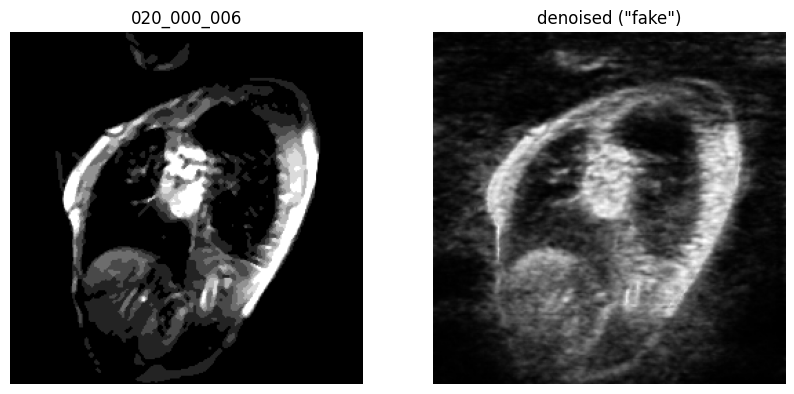

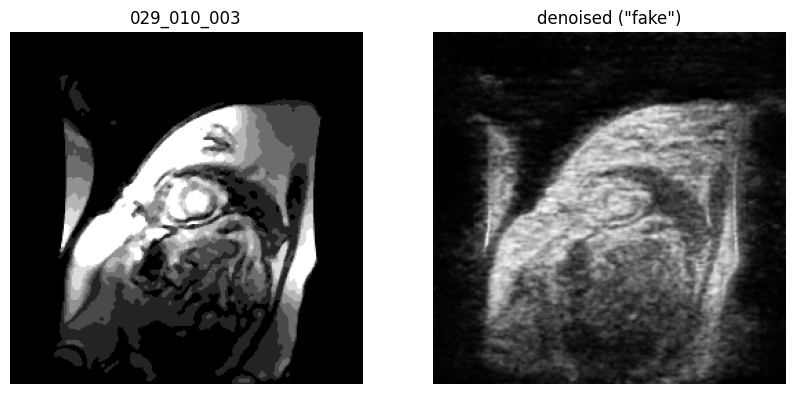

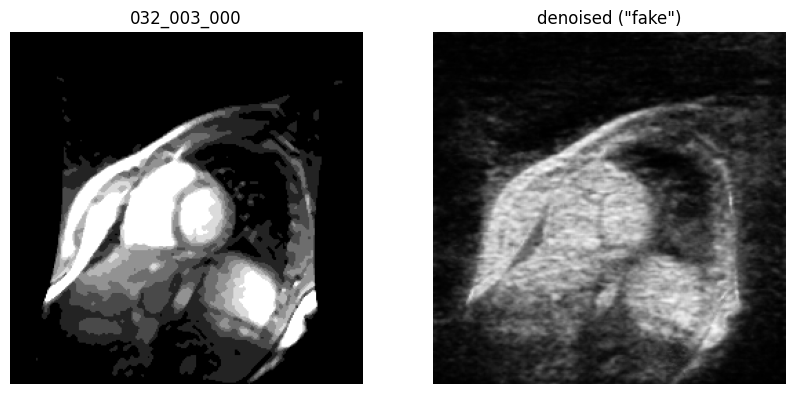

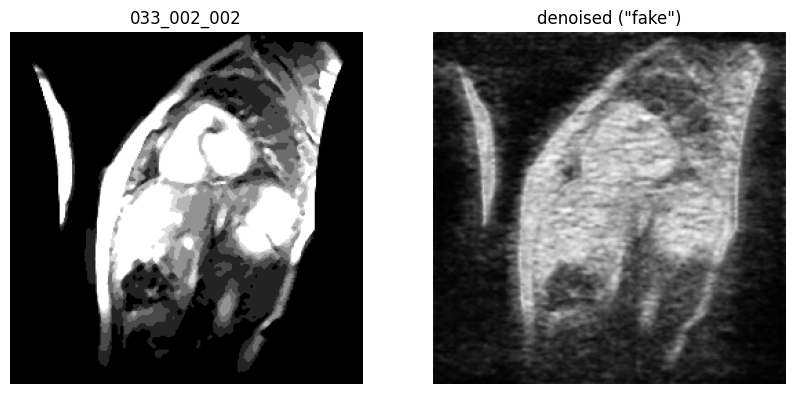

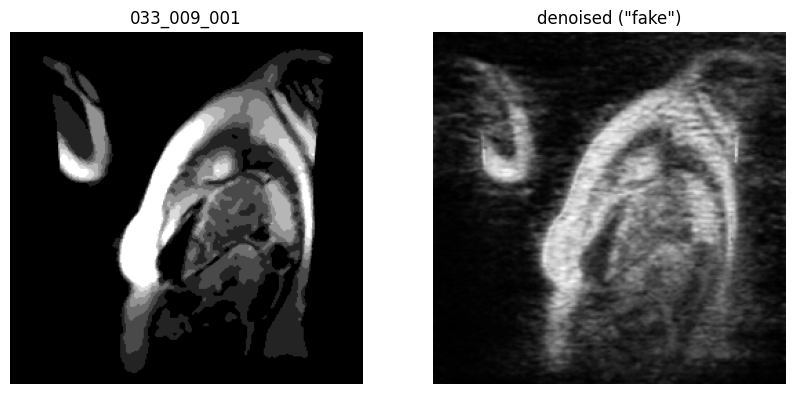

In [24]:
# visualize results

results_img_folder = os.path.join(RESULTS_DIR, 'test_latest/images/' )
list_real = [x for x in os.listdir(results_img_folder) if x.endswith('_real.png')]
list_real.sort()

for real_fname in list_real:
    fake_fname = real_fname[:-8]+'fake.png'

    img_real = cv2.imread(results_img_folder+real_fname, cv2.IMREAD_GRAYSCALE)
    img_fake = cv2.imread(results_img_folder+fake_fname, cv2.IMREAD_GRAYSCALE)

    fig, axs = plt.subplots(1, 2, figsize=(10, 10) )
    axs[0].imshow(img_real, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(real_fname[:-9])
    axs[1].imshow(img_fake, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('denoised (\"fake\")')

    # end of loop over images

**Demo of synthesis**

In [17]:
# folder containing model
CHECKPOINTS_DIR = 'USGAN_pix2pix_weights/US_simulator_GAN'

# folder to save results
RESULTS_DIR = "./Results_simulation"

if not( os.path.exists(RESULTS_DIR) ):
  os.makedirs(RESULTS_DIR)

# folder containing input images
DATAROOT = mri_lrr_path

**Apply synthesis model on MRI images.**

In [18]:
!python test.py --dataroot $DATAROOT --name . --model test --netG unet_256 --direction AtoB --norm batch --checkpoints_dir $CHECKPOINTS_DIR --results_dir $RESULTS_DIR --gpu_ids -1 --input_nc 1 --output_nc 1

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: USGAN_pix2pix_weights/US_simulator_GAN	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: ./sample_images_mri_lrr       	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: False                         	[default: Non

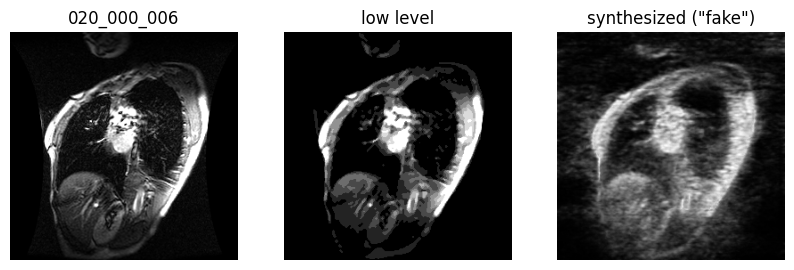

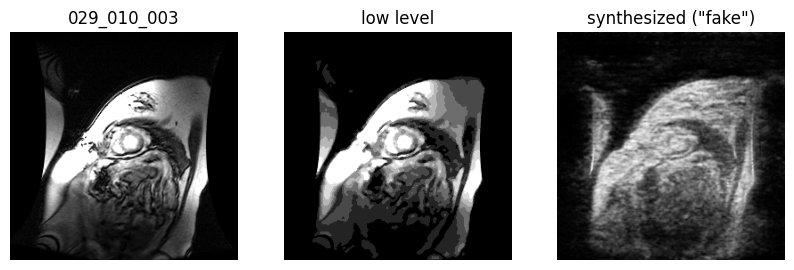

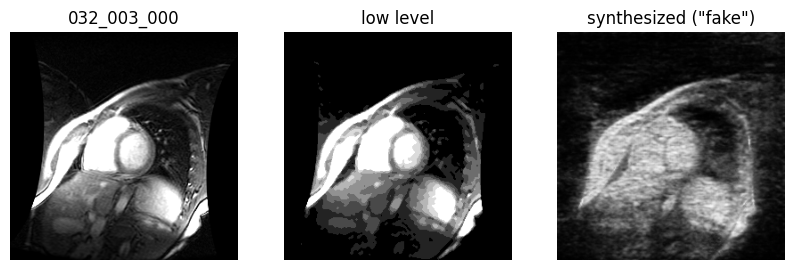

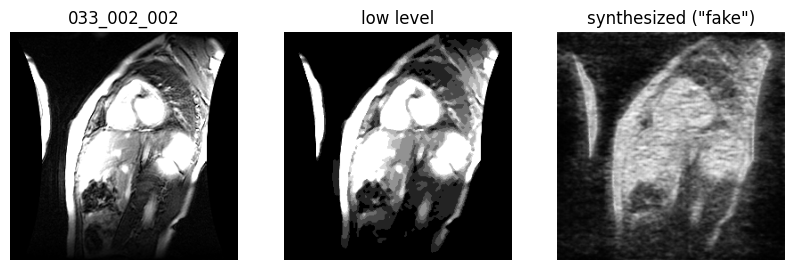

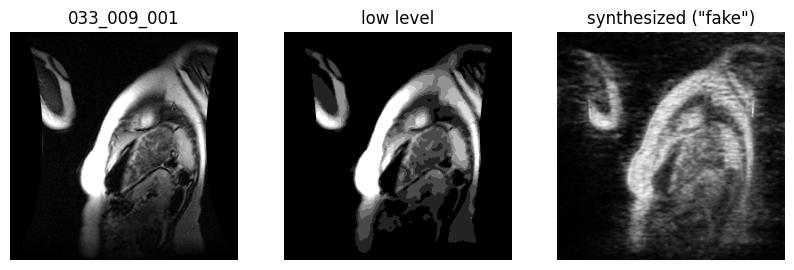

In [23]:
# visualize results

results_img_folder = os.path.join(RESULTS_DIR, 'test_latest/images/' )
list_real = [x for x in os.listdir(results_img_folder) if x.endswith('_real.png')]
list_real.sort()

for real_fname in list_real:
    fake_fname = real_fname[:-8]+'fake.png'

    img_in = cv2.imread( os.path.join( mri_path, real_fname.split('_real')[0]+'.png' ),\
                          cv2.IMREAD_GRAYSCALE )
    img_real = cv2.imread(results_img_folder+real_fname, cv2.IMREAD_GRAYSCALE)
    img_fake = cv2.imread(results_img_folder+fake_fname, cv2.IMREAD_GRAYSCALE)

    fig, axs = plt.subplots(1, 3, figsize=(10, 10) )
    axs[0].imshow(img_in, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(real_fname[:-9])
    axs[1].imshow(img_real, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('low level')
    axs[2].imshow(img_fake, cmap='gray')
    axs[2].axis('off')
    axs[2].set_title('synthesized (\"fake\")')

    # end of loop over images